In [1]:
import pandas as pd
import networkx as nx
import os
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('seaborn-white')
#### OUTPUT #####
fig_path = '/nas2/users/hermuba/fig'
data = pd.read_csv('~/nas2/integrate_net/rf.csv', index_col = 0)

# load gene annotation
base_path = '/home/hermuba/nas2/resist_subnet/'
annotation_df = os.path.join(base_path, 'gold_anno.csv')
gold_anno = pd.read_csv(annotation_df)
gold_anno.set_index('gene_id', inplace = True)
gold_anno_df = pd.read_pickle('/home/hermuba/nas2/parsed_anno/ecoli.gold_anno_df') # GO term in set 
gold_anno['GO'] = gold_anno['Unnamed: 0'].map(gold_anno_df['GO'])

gold_anno.index.set_names('Node', inplace = True)
gold_anno_str = gold_anno.copy()
gold_anno_str.index = [str(s) for s in gold_anno_str.index]
gold_anno_str['GO'] = gold_anno_str['GO'].astype(str)

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
from ddot import Ontology
pan_ont = Ontology.read_pickle('/home/hermuba/nas2/integrate_net/pan.annot.ddot')

# Functional enrichment comparing to resistant data

In [3]:
from glob import glob
scoary_result = '/nas2/users/hermuba/scoary'
# list of antibiotics
abx_list = [x.split('/')[-1].split('_')[0] for x in glob(scoary_result+'/*.results.csv')]

def read_scoary(abx):
    fname = os.path.join(scoary_result,'{}_08_02_2021_1335.results.csv').format(abx)
    df = pd.read_csv(fname, header = 0, index_col = 0)
    return df
def filter_scoary(df):
    
    return df.loc[(df['Benjamini_H_p']<0.05)& (df['Odds_ratio']>8)]
# join_abx_list
all_resistant_genes = set()
for abx in abx_list:
    resist_genes = filter_scoary(read_scoary(abx)).index.tolist()
    gene_ids = gold_anno.loc[gold_anno['cluster'].isin(resist_genes)].index
    all_resistant_genes.update(gene_ids)
    # binary df
resist_df = pd.DataFrame(columns = abx_list, index = list(all_resistant_genes))

for abx in abx_list:
    resist_genes = filter_scoary(read_scoary(abx)).index.tolist()
    gene_ids = gold_anno.loc[gold_anno['cluster'].isin(resist_genes)].index
    resist_df.loc[gene_ids, abx] = 1
resist_df.fillna(0, inplace = True)
resist_df = resist_df.loc[:, resist_df.sum(axis = 0)>0]

In [4]:
resist_df.head()

,piperacillin-tazobactam,chloramphenicol,tobramycin,tetracycline,ceftazidime,amoxicillin-clavunate,ciprofloxacin,trimethoprim,ampicillin,ceftriaxone,gentamicin,cefotaxime,streptomycin,meropenem,imipenem,amoxicillin,trimethoprim-sulfamethoxazole,amoxicillin-clavulanate,azithromycin,cefuroxime
36,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
47,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
50,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0


In [5]:
resist_df.index

Int64Index([  36,   46,   47,   48,   50,   51,   52,   74,   82,  147,
            ...
            3039, 3041, 3044, 3045, 3047, 3048, 3049, 3050, 3051, 3052],
           dtype='int64', length=2054)

In [6]:
# propagate_ontology
prop_pan = pan_ont.propagate()

In [7]:
prop_pan

1357 genes, 264 terms, 5319 gene-term relations, 278 term-term relations
node_attributes: ['Parent weight', 'Term index', 'Term', 'Name', 'Unnamed: 0', 'cog_ID', 'cog_category', 'cluster', 'count', 'core', 'is_card', 'Best_Hit_ARO', 'ARO', 'resfam', 'is_resfam', 'aclame_title', 'is_aclame', 'drug_target', 'is_drug_target', 'GO', 'cellular_component', 'molecular_function', 'biological_process', 'pathway', 'domain', 'nr', 'hypo_nr']
edge_attributes: ['CLIXO_score']

In [8]:
def get_contingency(term, drug, total_genes = len(prop_pan.genes)):
    ''' get contingency table of term versus drug resistant genes'''
    genes_belong_to_term = set([prop_pan.genes[i] for i in prop_pan.term_2_gene[term]])
    genes_indicated_by_drug = set([str(g) for g in resist_df[drug][resist_df[drug]>0].index]).intersection(set(prop_pan.genes))
    
    term_and_drug = len(genes_belong_to_term.intersection(genes_indicated_by_drug))
    term_not_drug = len(genes_belong_to_term - genes_indicated_by_drug)
    drug_not_term = len(genes_indicated_by_drug - genes_belong_to_term)
    neither = total_genes - term_and_drug - term_not_drug - drug_not_term
    
    return np.array([[term_and_drug, term_not_drug],[drug_not_term, neither]])

In [9]:
from scipy.stats import fisher_exact
import numpy as np
term_enrich_result_p = pd.DataFrame(index = prop_pan.terms, columns = resist_df.columns)
term_enrich_result_odd = pd.DataFrame(index = prop_pan.terms, columns = resist_df.columns)
for term in prop_pan.terms:
    for drug in resist_df.columns:
        term_enrich_result_p.loc[term, drug] = fisher_exact(get_contingency(term, drug))[1]
        term_enrich_result_odd.loc[term, drug] = fisher_exact(get_contingency(term, drug))[0]

In [11]:
term_enrich_result_count = pd.DataFrame(index = prop_pan.terms, columns = resist_df.columns)
for term in prop_pan.terms:
    for drug in resist_df.columns:
        genes_belong_to_term = set([prop_pan.genes[i] for i in prop_pan.term_2_gene[term]])
        genes_indicated_by_drug = set([str(g) for g in resist_df[drug][resist_df[drug]>0].index]).intersection(set(prop_pan.genes))
    
        term_and_drug = len(genes_belong_to_term.intersection(genes_indicated_by_drug))
        term_enrich_result_count.loc[term, drug] = term_and_drug

In [68]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
enrichment_result_path = os.path.join(fig_path, 'term_fisher.xlsx')
writer = pd.ExcelWriter(enrichment_result_path, engine='xlsxwriter')
term_enrich_result_p.to_excel(writer, sheet_name = 'p_value')
term_enrich_result_odd.to_excel(writer, sheet_name = 'odds_ratio')
term_enrich_result_count.to_excel(writer, sheet_name = 'gene_count')
pan_ont.node_attr.loc[pan_ont.node_attr['Term'].notnull(), ['Term', 'Name']].to_excel(writer, sheet_name = 'term annotation')
writer.save()

# Find shared term

In [13]:
common = term_enrich_result_p.le(0.05).sum(axis = 1)[term_enrich_result_p.le(0.05).sum(axis = 1)>1].sort_values()

In [39]:
str(pan_ont.node_attr.loc[term, 'Name']) =='nan'

True

In [15]:
# hand annotate from nr, inspect network in ndex
hand_annotation = {'S:1480':'antitoxin',
'S:1542':'Tellurium resistance',
'S:1589':'Ea22-like family protein',
'S:1599': 'glycosyltransferase',
'S:1531':'IS91 transposease',
'S:1422': 'Type I toxin-antitoxin(Hok)',
'S:1579':'Type IV secretion system RhS',
'S:1543': 'porphyrin biosynthesis protein; metalloprotease',
'S:1416': 'plasmid recombination protein'}

In [42]:
multiclass_binary = pd.DataFrame(columns = common.index, index = term_enrich_result_p.columns)
for c in common.index:
    for enriched_drug in term_enrich_result_p.loc[c][term_enrich_result_p.loc[c]<0.05].index:
        odds = term_enrich_result_odd.loc[c, enriched_drug]
        if odds == np.inf:
            multiclass_binary.loc[enriched_drug, c] = 500
        elif odds == -np.inf:
             multiclass_binary.loc[enriched_drug, c] = -500
        else:
            multiclass_binary.loc[enriched_drug, c] = odds
multiclass_binary.fillna(0, inplace = True)

for term in multiclass_binary.columns:
    if str(pan_ont.node_attr.loc[term, 'Name']) == 'nan':
        if term in hand_annotation.keys():
            multiclass_binary.loc['annot', term] = '{}({})'.format(hand_annotation[term], term)
        else:
            multiclass_binary.loc['annot', term] = '({})'.format(term)
    else:
        multiclass_binary.loc['annot', term] = '{}-{}({})'.format(pan_ont.node_attr.loc[term, 'Term'], pan_ont.node_attr.loc[term, 'Name'], term)

In [18]:
abx_category = pd.read_pickle('~/data0118/drug_category')
abx_category.loc['amoxicillin-clavulanate'] = abx_category.loc['amoxicillin/clavulanic acid']

In [19]:
abx_category.head()

,category,order,drug_color
drug,,,
ampicillin,penicillins,0.0,"(0.86, 0.3712, 0.33999999999999997)"
mecillinam,penicillins,0.0,"(0.86, 0.3712, 0.33999999999999997)"
ticarcillin,penicillins,0.0,"(0.86, 0.3712, 0.33999999999999997)"
pipercillin,penicillins,0.0,"(0.86, 0.3712, 0.33999999999999997)"
piperacillin,penicillins,0.0,"(0.86, 0.3712, 0.33999999999999997)"


In [43]:
multiclass_binary['category'] = multiclass_binary.index.map(abx_category['category'])
multiclass_binary['order'] = multiclass_binary.index.map(abx_category['order'])

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


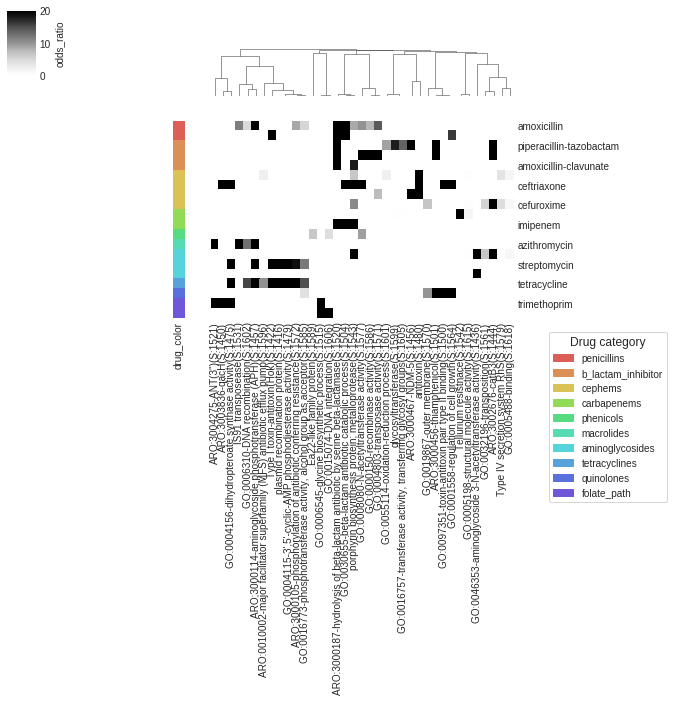

In [44]:


multiclass_binary = multiclass_binary.sort_values(by = 'order')
g = sns.clustermap(multiclass_binary.iloc[:-1, :-2].astype(float), xticklabels = multiclass_binary.loc['annot'], row_cluster = False,
               row_colors = abx_category.loc[multiclass_binary.index, 'drug_color'], vmax = 20, cmap = 'Greys', metric = 'correlation',
                   cbar_kws=dict(label='odds_ratio'), figsize = (8,5), annot_kws={"fontsize": 4})

lut4 = abx_category.loc[abx_category.index.isin(multiclass_binary.index)].set_index('category')['drug_color'].to_dict()
legend_TN = [mpatches.Patch(color=lut4[c],label=c) for c in lut4.keys()]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.1,-0.5),handles=legend_TN,frameon=True)
l2.set_title(title='Drug category',prop={'size':12}) # some have 2 classes
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'panresistome_term.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')